# Evaluation of GRN inference methods
## Processing results
### by Jalil Nourisa



# Imports

In [ ]:
# Reload and autoreload settings for modules
%reload_ext autoreload
%autoreload 2

# Import necessary libraries
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys
import numpy as np
import json
from scipy.stats import pearsonr
from pandas.api.types import CategoricalDtype
import seaborn
import matplotlib
from matplotlib.gridspec import GridSpec
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set plot parameters
plt.rcParams['font.family'] = 'Liberation Sans'  # Arial or 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)

# Add the src folder to the path
sys.path.insert(0, '../')
from src.helper import surrogate_names, colors_blind, palette_celltype, palette_methods, DATASETS, plot_heatmap

# Set paths for task grn inference
task_grn_inference_dir = '../../task_grn_inference' # IMPORTANT: set this to the path where you have the task_grn_inference repo
results_folder = f'{task_grn_inference_dir}/resources/results'
scores_dir = f'{results_folder}/'
run_id='replogle'# 'test_run' # 'all_main'

# Displace order for categories

models = ['celloracle', 'grnboost', 'pearson_corr', 'positive_control', 'negative_control',
            'scenicplus','granie','figr','scglue','scenic','ppcor', 'portia']

# Enable inline plotting in Jupyter
%matplotlib inline

['Liberation Sans']


In [ ]:
def read_yaml_raw(file_path):
    import yaml
    with open(file_path, 'r') as file:
        yaml_content = yaml.safe_load(file)
    print(yaml_content)
    record_store = []
    for entry in yaml_content:
        dataset_id = entry['dataset_id']
        method_id = entry['method_id']
        metric_ids = entry['metric_ids']
        metric_values = entry['metric_values']
        for metric_id, metric_value in zip(metric_ids, metric_values):
            record_store.append({
                'dataset_id': dataset_id,
                'method_id': method_id,
                'metric_id': metric_id,
                'metric_value': metric_value
            })
    df = pd.DataFrame(record_store)
    
    return df
def pivot_table(df):
    df = df.pivot(index=['dataset_id', 'method_id'], columns='metric_id', values='metric_value').reset_index()
    df.rename(columns={'dataset_id': 'dataset', 'method_id': 'model'}, inplace=True)
    return df
def read_yaml(file_path):
    df = read_yaml_raw(file_path).reset_index()
    df = df[df['dataset_id']!= 'missing']
    df = pivot_table(df)
    return df

def plot_raw_scores(df_all, dataset, ax):
    scores_mat = df_all[df_all['dataset'] == dataset]
    scores_mat = scores_mat.set_index('model').drop(columns='dataset')

    # Remove rows where all values are NaN
    scores_mat = scores_mat.dropna(how='all', axis=1)

    # Apply naming
    scores_mat.columns = scores_mat.columns.map(lambda name: surrogate_names.get(name, name))
    scores_mat.index = scores_mat.index.map(lambda name: surrogate_names.get(name, name))
    # Sort by order
    available_methods = [method for method in ORDERED_METHODS if method in scores_mat.index]
    scores_mat = scores_mat.loc[available_methods]
    
    # Plot heatmap
    # scores_mat = scores_mat.astype(float)
    plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
    # ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_ylabel('')

In [3]:
# trace = pd.read_csv(f"{task_grn_inference_dir}/resources/results/{run_id}/trace.txt", sep='\t')
# trace_df = process_trace(trace)
# trace_df
# # trace_df

# GRN inference and evaluation

GRN inference and evaluation are two seperate pipelines. Download and install https://github.com/openproblems-bio/task_grn_inference, then:
Inside `scripts/run_all.sh`, select the relevant step. GRN inference is very computational intensive.

# Download results
Once the results are obtained, run the following cells to download the results for this notebook.

In [ ]:
for dataset in DATASETS:
    !aws s3 sync s3://openproblems-data/resources/grn/results/{dataset} {results_folder}/{dataset} --no-sign-request

download: s3://openproblems-data/resources/grn/results/op/scenicplus/grn_extended.csv to ../../task_grn_inference/resources/results/op/scenicplus/grn_extended.csv
download: s3://openproblems-data/resources/grn/results/op/scenicplus/cell_topic.csv to ../../task_grn_inference/resources/results/op/scenicplus/cell_topic.csv
^Cmpleted 418.4 MiB/9.4 GiB (489.8 KiB/s) with 1 file(s) remaining
fatal error:                                                      


# Scores datasets

In [ ]:
process_trace = False

In [ ]:
def process_trace_func(trace):
    cols = ['%cpu', 'peak_rss', 'peak_vmem', 'rchar', 'wchar']
    datasets = DATASETS

    t_store = []
    for model in models:
        for i, row in trace.iterrows():
            if f'{model}_process' in row['name']:
                t = trace.loc[[i], cols]
                t['model'] = model

                for dataset in datasets:
                    if dataset in row['name']:
                        t['dataset'] = dataset
                        t_store.append(t)
                        break

    trace_df = pd.concat(t_store).reset_index()
    print(trace_df)
    if False:
        # Conversion factors
        unit_to_bytes = {
            "KB": 1024,
            "MB": 1024**2,
            "GB": 1024**3,
            "B": 1
        }

        def convert_to_gb(value):
            if pd.isna(value):
                return None
            value = str(value).strip()
            try:
                num, unit = value.split()
                num = float(num)
                unit = unit.upper()
                if unit in unit_to_bytes:
                    return num * unit_to_bytes[unit] / (1024**3)  # convert bytes → GB
                else:
                    return float(num)  # fallback if no unit
            except Exception:
                return None

        # - remove GB and MB from the columns
        # Apply conversion
        for col in ["peak_rss", "peak_vmem", "rchar", "wchar"]:
            trace_df[col] = trace_df[col].apply(convert_to_gb)

        # Rename columns with consistent units
        for col in ["%cpu"]:
            trace_df[col] = trace_df[col].str.replace(r"[^0-9.]", "", regex=True).astype(float)

        trace_df.rename(
            columns={
                "%cpu": "CPU Usage (%)",
                "peak_rss": "Peak RSS (GB)",
                "peak_vmem": "Peak VMem (GB)",
                "rchar": "Read Chars (GB)",
                "wchar": "Written Chars (GB)"
            },
            inplace=True
        )
    
    return trace_df
if True: # dataset specific results
    scores_store = []
    
    for dataset in DATASETS: 
        scores_file = f"{task_grn_inference_dir}/resources/results/{dataset}/score_uns.yaml"
        trace = pd.read_csv(f"{task_grn_inference_dir}/resources/results/{dataset}/trace.txt", sep='\t', index_col=0)
        df = read_yaml(scores_file)
        scores_store.append(df)
    scores_all = pd.concat(scores_store)
    scores_all.columns.name = ''

    if process_trace:
        trace_df_store = []
        for dataset in DATASETS: 
            scores_file = f"{task_grn_inference_dir}/resources/results/{dataset}/score_uns.yaml"
            trace = pd.read_csv(f"{task_grn_inference_dir}/resources/results/{dataset}/trace.txt", sep='\t', index_col=0)
            trace_df = process_trace_func(trace)
            trace_df_store.append(trace_df)
        trace_all = pd.concat(trace_df_store)
        if 'task_id' in trace_all.columns:
            trace_all = trace_all.drop(columns=['task_id'])
        trace_all.index.name = ''
        assert scores_all['model'].unique().tolist() == trace_all['model'].unique().tolist(), "Trace data does not match expected models"
else:
    scores_file = f"{task_grn_inference_dir}/resources/results/{dataset}/scores.yaml"
    scores_all = read_yaml(scores_file)

[{'dataset_id': 'xaira_HEK293T', 'date_created': '07-09-2025', 'file_size': 23048, 'method_id': 'portia', 'metric_ids': ['r2-theta-0.0', 'r2-theta-0.5', 'r2-theta-1.0'], 'metric_values': [nan, 0.008603043709195393, 0.0047397708682745225]}, {'dataset_id': 'xaira_HEK293T', 'date_created': '07-09-2025', 'file_size': 23048, 'method_id': 'scenic', 'metric_ids': ['ws-theta-0.0', 'ws-theta-0.5', 'ws-theta-1.0'], 'metric_values': [0.6004288499025341, 0.5367446773931416, 0.5186052688874374]}, {'dataset_id': 'xaira_HEK293T', 'date_created': '07-09-2025', 'file_size': 23048, 'method_id': 'pearson_corr', 'metric_ids': ['r2-theta-0.0', 'r2-theta-0.5', 'r2-theta-1.0'], 'metric_values': [nan, 0.0447230528430358, 0.010706342061025225]}, {'dataset_id': 'xaira_HEK293T', 'date_created': '07-09-2025', 'file_size': 23048, 'method_id': 'scprint', 'metric_ids': ['ws-theta-0.0', 'ws-theta-0.5', 'ws-theta-1.0'], 'metric_values': [0.5886868096166342, 0.5292159921989273, 0.517628238623993]}, {'dataset_id': 'xair

In [6]:
# scores_all = scores_all[['dataset', 'model', 'r2-theta-0.0', 'r2-theta-0.5', 'r2-theta-1.0']]

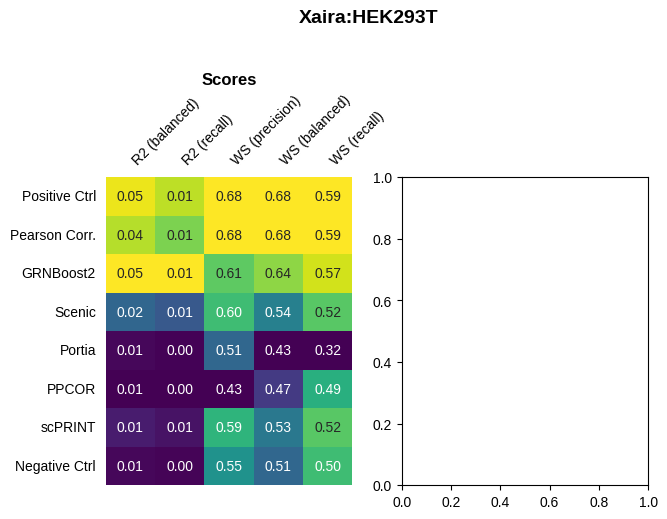

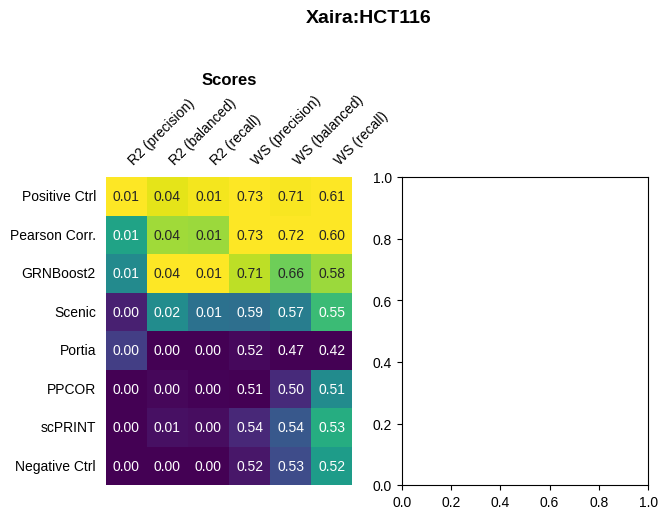

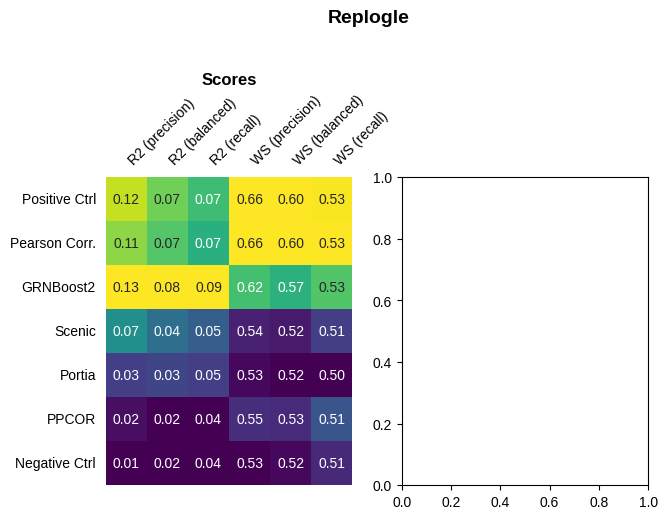

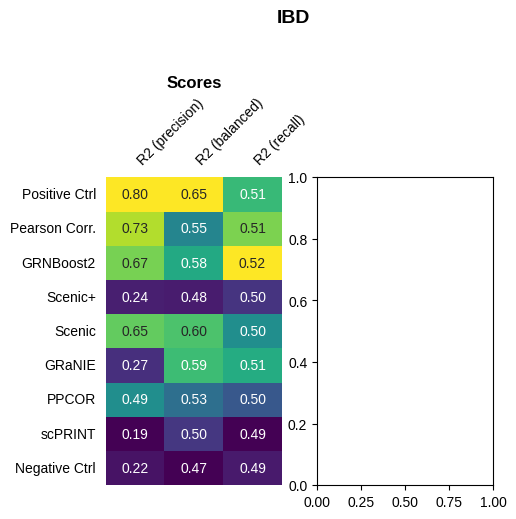

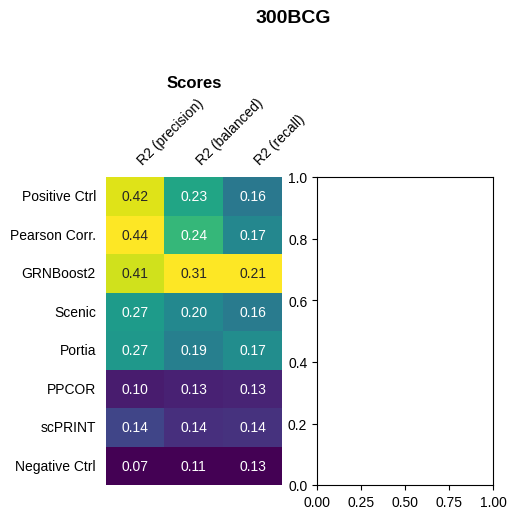

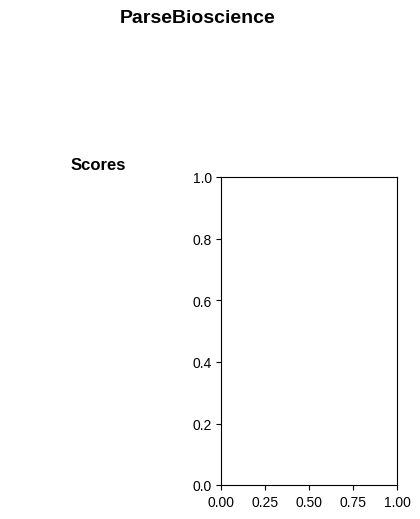

In [6]:
from src.helper import ORDERED_METHODS

# Plot figures
for dataset in ['xaira_HEK293T', 'xaira_HCT116', 'replogle', 'ibd', '300BCG',  'parsebioscience']: #DATASETS
    if dataset == 'op':
        figsize=(3, 6)
    else:
        figsize=(5, 4)
    if dataset in ['norman','adamson','replogle', 'xaira_HCT116', 'xaira_HEK293T']:
        figsize=(7, 4)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)
    ax = axes[0]
    plot_raw_scores(scores_all, dataset, ax)
    ax.set_title('Scores', fontsize=12, weight='bold')
    # ax = axes[1]
    # plot_raw_scores(trace_all, dataset, ax)
    # ax.set_title('Trace', fontsize=12, weight='bold')

    plt.suptitle(surrogate_names.get(dataset, dataset), y=1.3, fontsize=14, weight='bold')
    fig.savefig(f"{results_folder}/figs/raw_scores_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')
    fig.savefig(f"{task_grn_inference_dir}/docs/source/images/raw_scores_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')

# Overview of performance

## Format resourcs used

In [8]:
df_res = pd.read_csv(f'{task_grn_inference_dir}/resources/results/trace.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '../../task_grn_inference/resources/results/trace.csv'

## Merge scores with resources

In [28]:
# - read the scores
metrics = df_all.drop(['model', 'dataset'], axis=1).columns.values

In [29]:
# - s1 and s2 only for op 
df_store = []
for dataset in df_all['dataset'].unique():
    df_dataset = df_all[df_all['dataset']==dataset].copy()
    if dataset != 'op':
        df_dataset[['r1_grn', 'r1_all']] = np.nan
    df_store.append(df_dataset)
    
df_all_adj = pd.concat(df_store)

In [30]:
# - normalize the scores
def normalize_scores_per_dataset(df):
    df = df.set_index('model')
    df[df < 0] = 0
    df = (df-df.min(axis=0))/(df.max(axis=0)-df.min(axis=0))
    # df = df.rank(axis=0, ascending=False, method="min") 
    return df
df_all_n = df_all_adj.groupby('dataset').apply(normalize_scores_per_dataset).reset_index()

In [31]:
# - average scores for all datasets 
def mean_for_metrics(df):
    # Calculate mean across datasets for each metric, ignoring NaN values
    return df.drop(['dataset'], axis=1).mean(skipna=True)

df_metrics = (
    df_all_n.groupby(['model'])
    .apply(mean_for_metrics)
)
df_metrics

,r1_all,r1_grn,r2-theta-0.0,r2-theta-0.5,r2-theta-1.0,ws-theta-0.0,ws-theta-0.5,ws-theta-1.0
model,,,,,,,,
celloracle,0.718068,0.611809,0.857593,0.785095,0.576195,NaN,NaN,NaN
figr,0.335390,0.435786,0.304739,0.333618,0.293318,NaN,NaN,NaN
granie,0.226975,0.155449,0.000000,0.000000,0.000000,NaN,NaN,NaN
grnboost2,1.000000,0.696734,0.787823,0.956492,0.998468,0.867331,0.934401,0.957564
negative_control,0.000000,0.000000,0.087315,0.198094,0.062898,0.000000,0.000000,0.106084
pearson_corr,0.878308,0.841066,0.753392,0.747390,0.619582,0.915898,0.888967,0.793677
portia,0.717270,0.541042,0.339647,0.221606,0.185991,0.401950,0.322657,0.358325
positive_control,0.986997,1.000000,0.916171,0.835388,0.709178,0.734640,0.698156,0.687429
ppcor,0.302937,0.191347,0.310960,0.282854,0.176127,0.328084,0.201946,0.193808


In [32]:
# - average scores for all datasets 
def mean_for_datasets(df):
    # print(df.set_index('dataset')[metrics].T.mean(skipna=True))
    return df.set_index('dataset')[metrics].T.mean(skipna=True)

df_datasets = (
    df_all_n.groupby(['model'])
    .apply(mean_for_datasets)
    .reset_index()
)
df_datasets = df_datasets.pivot(index='model',columns='dataset',values=0)
df_datasets

dataset,adamson,nakatake,norman,op,replogle
model,,,,,
celloracle,NaN,NaN,NaN,0.709752,NaN
figr,NaN,NaN,NaN,0.340570,NaN
granie,NaN,NaN,NaN,0.076485,NaN
grnboost2,1.000000,0.673701,0.963005,0.922303,0.879648
negative_control,0.069245,0.000000,0.152568,0.082131,0.053042
pearson_corr,0.776850,0.615576,0.854703,0.741831,0.795269
portia,0.266806,0.147224,0.178645,0.551471,0.395266
positive_control,0.546719,0.922864,0.864949,0.902426,0.816771
ppcor,0.298239,0.026172,0.421740,0.291087,0.110281


## Calculate overal scores

In [33]:
# - calculate over scores
df_scores = pd.concat([df_metrics, df_datasets], axis=1)
# df_scores = df_metrics
df_scores['overall_score'] = df_scores.mean(axis=1, skipna=True)

# - merge scores with resources 
df_summary = pd.concat([df_scores, df_res], axis=1)
df_summary = df_summary.fillna(0)
df_summary.index.name = 'method_name' 
df_summary = df_summary.reset_index()

df_summary = df_summary.sort_values(by='overall_score', ascending=False) 
df_summary
df_summary.method_name = df_summary.method_name.map(surrogate_names)
# - add user complexity 
df_summary['User-friendly'] = df_summary['method_name'].map({
                            'Scenic+': 1, 
                            'GRNBoost2': 8, 
                            'Positive Ctrl': 10, 
                            'Pearson Corr.': 10,
                            'CellOracle': 6,
                            'Portia': 9,
                            'scGLUE': 6,
                            'Scenic': 7,
                            'FigR': 6,
                            'PPCOR': 7,
                            'Negative Ctrl': 10,
                            'GRaNIE': 6,
                            'scPRINT': 5
                            })
df_summary['Complexity'] = df_summary['User-friendly'].max() - df_summary['User-friendly']
df_summary.columns = [surrogate_names.get(col, col) for col in df_summary.columns]

df_summary= df_summary.fillna(0)
df_summary

,method_name,R1 (all),R1 (grn),R2 (precision),R2 (balanced),R2 (recall),WS (precision),WS (balanced),WS (recall),Adamson,Nakatake,Norman,OPSCA,Replogle,overall_score,Duration (hour),Peak memory (GB),User-friendly,Complexity
3,GRNBoost2,1.000000,0.696734,0.787823,0.956492,0.998468,0.867331,0.934401,0.957564,1.000000,0.673701,0.963005,0.922303,0.879648,0.895190,150.211111,7.378796,8,2
10,Scenic+,0.906689,0.604689,0.910277,1.000000,0.986145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.881560,0.000000,0.881560,234.811111,131.342854,1,9
7,Positive Ctrl,0.986997,1.000000,0.916171,0.835388,0.709178,0.734640,0.698156,0.687429,0.546719,0.922864,0.864949,0.902426,0.816771,0.817053,0.300000,11.601669,10,0
5,Pearson Corr.,0.878308,0.841066,0.753392,0.747390,0.619582,0.915898,0.888967,0.793677,0.776850,0.615576,0.854703,0.741831,0.795269,0.786347,0.827778,23.801899,10,0
0,CellOracle,0.718068,0.611809,0.857593,0.785095,0.576195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.709752,0.000000,0.709752,75.300000,41.601166,6,4
9,Scenic,0.449429,0.342807,0.463307,0.500715,0.441272,0.812153,0.608982,0.434923,0.649043,0.364819,0.446250,0.623635,0.433748,0.505468,480.172222,35.954300,7,3
11,scGLUE,0.239761,0.544760,0.715635,0.315179,0.194444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.401956,0.000000,0.401956,221.950000,61.677879,6,4
6,Portia,0.717270,0.541042,0.339647,0.221606,0.185991,0.401950,0.322657,0.358325,0.266806,0.147224,0.178645,0.551471,0.395266,0.355992,49.822222,55.685230,9,1
1,FigR,0.335390,0.435786,0.304739,0.333618,0.293318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.340570,0.000000,0.340570,134.633333,225.208725,6,4
12,scPRINT,0.168731,0.151688,0.439924,0.471631,0.391075,0.263764,0.198115,0.232160,0.000000,0.000000,0.569322,0.254374,0.154764,0.299595,0.000000,0.000000,5,5


## Summary figure

In [34]:
summary_file = f"{results_folder}/summary.tsv"
summary_figure = f"{results_folder}/summary_figure"

df_summary['memory_log'] = np.log(df_summary['Peak memory (GB)']+1)
df_summary['memory_log'] = np.max(df_summary['memory_log'])-df_summary['memory_log']

df_summary['complexity_log'] = np.log(df_summary['Complexity']+1)
df_summary['complexity_log'] = np.max(df_summary['complexity_log'])-df_summary['complexity_log']

df_summary["duration_log"] = np.log(df_summary['Duration (hour)']+1)
df_summary['duration_log'] = np.max(df_summary['duration_log'])-df_summary['duration_log']

df_summary["duration_str"] = df_summary['Duration (hour)'].round(1).astype(str)
df_summary['memory_str'] =  df_summary['Peak memory (GB)'].round(1).astype(str)

df_summary.to_csv(summary_file, sep='\t')

!Rscript ../src/summary_figure.R {summary_file} {summary_figure}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.5.1     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.1     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
`thisfile()` was deprecated in rprojroot 2.0.0.
ℹ Please use `whereami::thisfile()` instead. 
New names:
• `` -> `...1`
Rows: 13 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): method_name
dbl (24): ...1, R1 (all), R1 (grn), R2 (precision), R2 (balanced), R2 (recal...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 13 × 26
    ...1 method_name   `R1 (all)` `R1 (grn)` `R2 (precision)` `R2 (balanced)`
   <dbl